# Wind-driven upwelling - 2 layer SWE analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
import yaml
from datetime import datetime, timedelta
from dateutil.parser import parse
from cmocean import cm
from tqdm import tqdm_notebook as tqdm
from dynmodes import dynmodes
from salishsea_tools import viz_tools, geo_tools
from scipy import signal
from scipy.interpolate import griddata
from warnings import simplefilter
from copy import copy

%matplotlib inline
simplefilter('ignore')

In [2]:
plt.rcParams['font.size'] = 12

***

### Local functions

In [3]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix


def calc_rho(data, depth, tmask):
    """Calculate the density, rho
    """
    
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[k]) for k in tracers], depth)
    
    return rho

In [4]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: subdomains, _, events_northerly, events_southerly = yaml.safe_load_all(f)

HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = bathy.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))
mask = mask.isel(x=slice(*subdomains['ideal'][:2]), y=slice(*subdomains['ideal'][2:]))

# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tmask = mask.tmask[0, ...]
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, radius, jmin, jmax, jsub = 24, 440, 2, 30, 370, 5
e3t = mask.e3t_1d[0, :].values
tracers = ['vosaline', 'votemper']

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Build storage dict
runs = {}
for z_h in param['z_h']:
    runs[z_h] = {}
    for rho_s in param['rho_surf']:
        runs[z_h][rho_s] = {}
        for U in param['u_wind']:
            runs[z_h][rho_s][U] = {}
            for key in ['z_u', 'x_u']:
                runs[z_h][rho_s][U][key] = []

***

### Define coastline indices, angles and bottom slope

In [5]:
# Make coastline indices
mask_trimmed = mask.tmask[0, ...].values
mask_trimmed[:, :130, :125] = 0
mask_trimmed[:, :50, :147] = 0
ileft = [147]
iright = [150]
width = []
for row_s, row_d in zip(mask_trimmed[0, ...], mask_trimmed[30, ...]):
    i_s = np.where(abs(np.diff(row_s)) > 0)[0]
    i_d = np.where(abs(np.diff(row_d)) > 0)[0]
    if i_d.size:
        i_s_left = i_s[i_s < i_d[0]]
        if i_s_left.size:
            ileft.append(i_s_left[-1])
            iright.append(i_s[int(np.where(i_s == i_s_left[-1])[0]) + 1])
        else:
            ileft.append(ileft[-1])
            iright.append(iright[-1])
    else:
        ileft.append(ileft[-1])
        iright.append(iright[-1])

# Process arrays
ileft = ileft[1:]
window = signal.get_window('blackman', 50)
index_smooth = signal.convolve(ileft, window / sum(window), mode='same')
slope = np.diff(index_smooth)
jindex = mask.y[jmin:jmax][::jsub].values
ileft = ileft[jmin:jmax][::jsub]
slope = slope[jmin:jmax][::jsub]

# Calculate widths
#iright = iright[1:]
#iright = iright[jmin:jmax][::jsub]
#for j, il, s in zip(jindex, ileft, slope):
#    if s > 0: line = -(jindex - j) / 0 + il
#    else: line = -(jindex - j) / s + il
#    idx = np.argwhere(np.diff(np.sign(line - iright))).flatten()[0]
#    width.append(np.sqrt((iright[idx] - il)**2 + (jindex[idx] - j)**2)*e1t)

# Calculate bottom slope
bottom = np.empty((0, 50))
for j, i in zip(jindex, ileft):
    bottom = np.concatenate((bottom, bathy.Bathymetry[j, i:i+50].values[np.newaxis, :]))

bottom[bottom > 200] = 200
alpha = np.nanmax(bottom, axis=1) / np.cos(np.arctan(slope)) / np.nanargmax(bottom, axis=1) / 440

# Calculate wind indices
ileft_HRDPS, jindex_HRDPS = [], []
for ii, jj in zip(ileft, jindex):
    j, i = geo_tools.find_closest_model_point(
        mask.glamt[0, jj, ii].values, mask.gphit[0, jj, ii].values,
        grid_HRDPS.longitude-360, grid_HRDPS.latitude, grid='GEM2.5',
        tols={'NEMO': {'tol_lon': 0.0104, 'tol_lat': 0.00388}, 'GEM2.5': {'tol_lon': 0.017, 'tol_lat': 0.017}}
    )
    ileft_HRDPS.append(i)
    jindex_HRDPS.append(j)

***

## Process runs

### Idealized

In [6]:
# Loop though z_h, rho_surf and tau
for z_h in tqdm(param['z_h']):
    for rho_s in param['rho_surf']:
        
        # Calculate R
        N = np.sqrt(const['g'] / const['rho_0'] * (const['rho_0'] - rho_s) / z_h)
        runs[z_h][rho_s]['N'] = N
        R = N * z_h / const['f']
        
        # Loop through windspeed
        for U in param['u_wind']:

            # Open results record
            runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
            file = os.path.join(path, runID, fn)
            if os.path.exists(file):
                with xr.open_dataset(file) as data:
                    
                    # Loop through sections
                    for i, j, s in zip(ileft, jindex, slope):
                        
                        # Lengthscale
                        L = int(radius * R / abs(np.cos(np.arctan(s))) / e1t)
                        
                        # Calculate stratification parameters
                        rho_t0 = calc_rho(data.isel(time_counter=0, y=j, x=slice(i, None)), depth2d, tmask[:, j, i:])
                        rho_halo = rho_t0[abs(depth2d[:, 0] - z_h).argmin(axis=0), :L].mean()

                        # Calculate upwelling metrics
                        rho = calc_rho(data.isel(time_counter=hour, deptht=0, y=j, x=slice(i, None)), 0, tmask[0, j, i:])
                        rho_max = rho[:L].max()
                        z_u = depth2d[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0))), 0]
                        x_u = np.cos(np.arctan(s)) * (rho >= rho_halo).sum() * e1t
                        runs[z_h][rho_s][U]['z_u'].append(z_u)
                        runs[z_h][rho_s][U]['x_u'].append(x_u)

### Hindcast

In [6]:
# Define paths and variables
path_NEMO = '/results2/SalishSea/nowcast-green.201812'
depthw = (depth2d[1:, 0] + depth2d[:-1, 0]) / 2
xsub, ysub = subdomains['ideal'][0], subdomains['ideal'][2]

In [41]:
# Loop though events and hours
runs = {}
for date in tqdm(events_southerly):
    dateobj = parse(date)
    datestr = dateobj.strftime('%Y%b%d')
    runs[datestr] = {'date': dateobj, 'N': [], 'rho_s': [], 'rho_halo': [], 'z_h': [], 'tau': [], 'z_u': [], 'x_u': []}
    Rho_t0 = []

    # Loop through hours
    for hour in [0, hour]:
        time = dateobj + timedelta(hours=hour)

        # Open hindcast record
        with xr.open_dataset(make_prefix(time, path_NEMO) + '_grid_T.nc') as data:

            # Loop through sections
            for n, i, ii, j, jj, s in zip(range(len(jindex)), ileft, ileft_HRDPS, jindex, jindex_HRDPS, slope):

                # Calculations at t=0
                if hour == 0:

                    # Calculate stratification parameters
                    rho_t0 = calc_rho(data.sel(time_counter=time, method='nearest').isel(y=ysub+j, x=slice(xsub+i, None)), depth2d, tmask[:, j, i:])
                    N2 = const['g'] / const['rho_0'] * np.diff(rho_t0, axis=0) / np.diff(depth2d, axis=0)
                    L = None
                    for itr in range(2):
                        modes = dynmodes(np.ma.median(N2[:, :L], axis=1).compressed()[:24], depthw[:24], 1)
                        z_h = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
                        rho_s = rho_t0[:int(z_h), :L].mean()
                        N = np.sqrt(const['g'] / const['rho_0'] * (const['rho_0'] - rho_s) / z_h)
                        R = N * z_h / const['f']
                        L = int(radius * R / abs(np.cos(np.arctan(s))) / e1t)
                    runs[datestr]['rho_halo'].append(np.nanmedian(rho_t0[abs(depth2d[:, 0] - z_h).argmin(axis=0), :L].data))
                    runs[datestr]['N'].append(N)
                    runs[datestr]['rho_s'].append(rho_s)
                    runs[datestr]['z_h'].append(z_h)
                    Rho_t0.append(rho_t0)

                # Calculations at hours
                else:

                    # Calculate tau
                    u, v = [
                        HRDPS.sel(time=slice(dateobj, time))[k].values[:, jj, slice(ii, ii+10)]
                        for k in ['u_wind', 'v_wind']
                    ]
                    coeff = np.sin(np.pi * (22 / 180 + 1) - np.arctan2(v, u) - np.arctan(s))
                    runs[datestr]['tau'].append(sum(1.225e-3 * (coeff * np.sqrt(u**2 + v**2)).mean(axis=1)**2) * 3600)

                    # Calculate upwelling metrics
                    rho = calc_rho(data.sel(time_counter=time, method='nearest').isel(y=ysub+j, x=slice(xsub+i, None)), 0, tmask[:, j, i:])
                    R = runs[datestr]['N'][n] * runs[datestr]['z_h'][n] / const['f']
                    L = int(radius * R / abs(np.cos(np.arctan(s))) / e1t)
                    rho_max = rho[:L].max()
                    runs[datestr]['z_u'].append(depth2d[int(np.median(abs(Rho_t0[n][:, :L] - rho_max).argmin(axis=0))), 0])
                    runs[datestr]['x_u'].append(np.cos(np.arctan(s)) * (rho >= runs[datestr]['rho_halo'][n]).sum() * e1t)

***

### Plot results

In [27]:
def plot_results():
    """
    """
    
    # Init arrays and make plot area
    x, y, zh, z_u, x_u, s, ones = np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.empty(0), np.ones(len(jindex))
    fig, axs = plt.subplots(1, 4, figsize=(13, 8), gridspec_kw={'width_ratios': [1, 1, 0.5, 2], 'wspace': 0.1})
    caxs = [fig.add_axes([xpos, 0.02, 0.16, 0.01]) for xpos in [0.125, 0.305]]

    # Wind integration factor
    components = np.sin(np.arctan(2) - np.arctan(slope)) * (hour - 3) * 3600
    
    # Concatenate arrays across runs
    for z_h in param['z_h']:
        for rho_s in param['rho_surf']:
            for U, t in zip(param['u_wind'], param['tau']):
                R = runs[z_h][rho_s]['N'] * z_h / const['f']
                x = np.concatenate((x, t * components / (const['rho_0'] * z_h**2 * runs[z_h][rho_s]['N'])))
                y = np.concatenate((y, jindex))
                zh = np.concatenate((zh, z_h*ones))
                z_u = np.concatenate((z_u, np.array(runs[z_h][rho_s][U]['z_u']) / z_h))
                x_u = np.concatenate((x_u, np.array(runs[z_h][rho_s][U]['x_u']) / R))
                s = np.concatenate((s, alpha))
    
    # Interpolate to contour grid and plot results
    xi, yi = np.meshgrid(np.arange(0, 4, 0.1), np.arange(jmax))
    x1, x2 = copy(x), copy(x)
    x1[x1 > 1], x2[x2 < 1] = 1, 1
    for ax, cax, z, label in zip(axs[:2], caxs, [z_u-x1, x_u-x2+1], ['$\eta h^{-1} - ftW^{-1}$', '$\Delta xL_R^{-1} - (ftW^{-1} - 1)$']):
        data = griddata((x, y), z, (xi, yi), method='linear')
        c = ax.contourf(xi, yi, data, levels=np.arange(-2, 2.1, 0.1), cmap=cm.balance, extend='both')
        ax.plot(x, y, 'ko', markersize=2)
        ax.set_xlim([0, 3.2])
        ax.set_xlabel('$ftW^{-1}$')
        fig.colorbar(c, cax=cax, orientation='horizontal', label=label, ticks=[-2, -1, 0, 1, 2])

    # Plot wind angle geometry
    axs[2].plot(alpha, jindex, 'k-')
    axs[2].set_xlim([0, 0.1])
    axs[2].set_xlabel('Bottom Slope')

    # Plot coastline reference
    c = axs[3].contourf(bathy.Bathymetry, cmap=cm.deep, levels=np.arange(0, 451, 50), extend='max')
    axs[3].contourf(tmask[0, ...], levels=[-0.01, 0.01], colors='lightgray')
    axs[3].contour(tmask[0, ...], levels=[-0.01, 0.01], colors='k')
    axs[3].plot(ileft, jindex, '-', color='magenta')
    axs[3].plot(ileft+np.nanargmax(bottom, axis=1), jindex, '-', color='w')
    axs[3].set_xlim([0, 250])
    axs[3].set_xlabel('Subdomain grid X')
    viz_tools.set_aspect(axs[3])
    for ax, col in zip(axs, range(4)):
        ax.set_ylim([30, 365])
        if col > 0: ax.yaxis.set_ticklabels('')
        else: ax.set_ylabel('Subdomain grid Y')
            
    # Add colorbar for model bathymetry
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='Depth [m]')

    return fig, axs, x, zh, x_u, z_u, s

### Longshore dependence of upwelling behavior

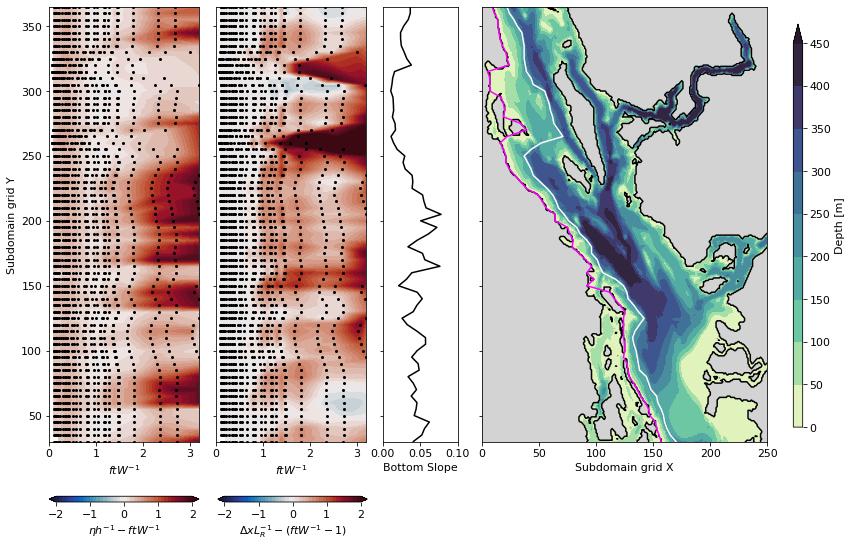

In [28]:
fig, axs, x, zh, x_u, z_u, s = plot_results()
fig.savefig('/home/bmoorema/Desktop/idealized_results.pdf', bbox_inches='tight')

### Topographic dependence (Burger number)

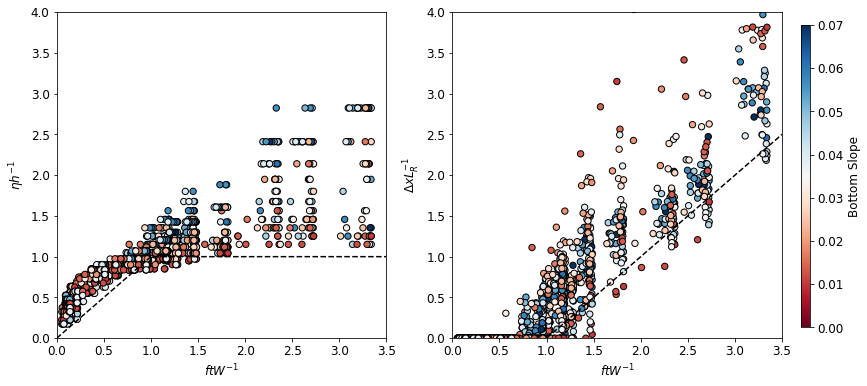

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(13, 6))
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
for ax in axs:
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 4])
    ax.set_xlabel('$ftW^{-1}$')

axs[0].plot([0, 1, 3.5], [0, 1, 1], 'k--')
c = axs[0].scatter(x, z_u, s=40, c=s, vmin=0, vmax=0.07, edgecolor='k', cmap='RdBu')
axs[0].set_ylabel('$\\eta h^{-1}$')

axs[1].plot([1, 3.5], [0, 2.5], 'k--')
axs[1].scatter(x, x_u, s=40, c=s, vmin=0, vmax=0.07, edgecolor='k', cmap='RdBu')
axs[1].set_ylabel('$\Delta xL_R^{-1}$')

fig.colorbar(c, cax=cax, label='Bottom Slope')

fig.savefig('/home/bmoorema/Desktop/idealized_bottomslope.pdf', bbox_inches='tight')

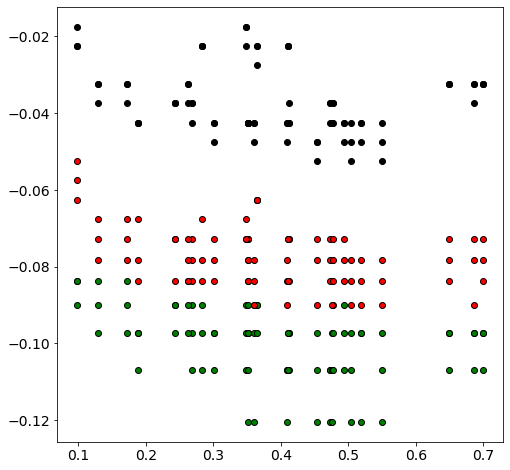

In [121]:
fig, ax = plt.subplots(figsize=(8, 8))
z_h = 20
for rho_s in param['rho_surf']:
    for U, t, color in zip(param['u_wind'], param['tau'], ['k', 'r', 'g']):
        S = 0.001 * alpha / const['f']
        ax.plot(S[20:-20], -np.array(runs[z_h][rho_s][U]['z_u'])[20:-20] / const['H'], 'ko', markerfacecolor=color)

***

## Constant stratification runs

In [64]:
path = '/data/bmoorema/results/Lake/S4d_Nconst'
Nlist = np.arange(0.01, 0.026, 0.0025)
runs_Nconst = {}

In [75]:
# Loop though z_h, rho_surf and tau

for N in tqdm(Nlist):
    
    runs_Nconst[N] = {}
    # Calculate R
    R = N * const['H'] / const['f']

    # Loop through windspeed
    for U in param['u_wind']:

        runs_Nconst[N][U] = {'z_u': []}
        # Open results record
        runID = f'SalishSeaPond_S4d{U:02d}ms_N{Nval*1e4:04.0f}s'
        file = os.path.join(path, runID, fn)
        if os.path.exists(file):
            with xr.open_dataset(file) as data:

                # Loop through sections
                for i, j, s in zip(ileft, jindex, slope):

                    # Lengthscale
                    L = 20 #int(radius * R / abs(np.cos(np.arctan(s))) / e1t)

                    # Calculate stratification parameters
                    rho_t0 = calc_rho(data.isel(time_counter=0, y=j, x=slice(i, None)), depth2d, tmask[:, j, i:])

                    # Calculate upwelling metrics
                    rho = calc_rho(data.isel(time_counter=hour, deptht=0, y=j, x=slice(i, None)), 0, tmask[0, j, i:])
                    rho_max = rho[:L].max()
                    z_u = depth2d[int(np.median(abs(rho_t0[:, :L] - rho_max).argmin(axis=0))), 0]
                    runs_Nconst[N][U]['z_u'].append(z_u)

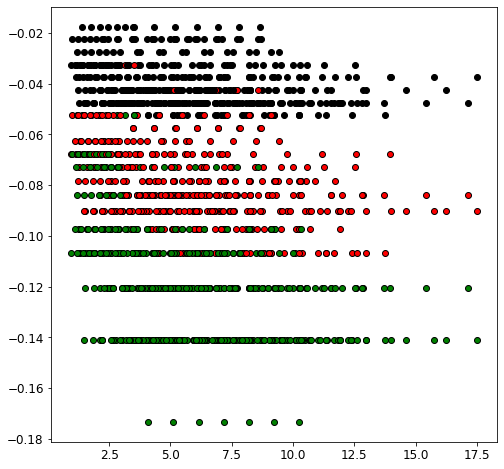

In [76]:
fig, ax = plt.subplots(figsize=(8, 8))
for N in Nlist:
    for U, t, color in zip(param['u_wind'], param['tau'], ['k', 'r', 'g']):
        S = N * alpha / const['f']
        ax.plot(S, -np.array(runs_Nconst[N][U]['z_u']) / const['H'], 'ko', markerfacecolor=color)

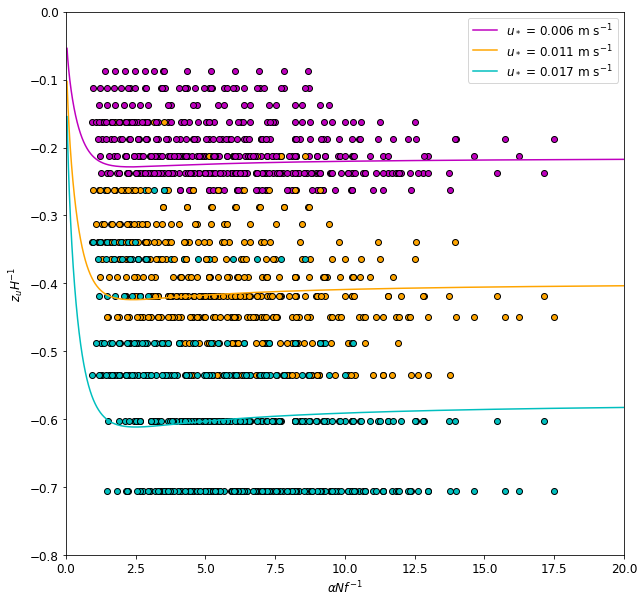

In [117]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim([0, 20])
ax.set_ylim([-0.8, 0])
ax.set_xlabel('$\\alpha Nf^{-1}$')
ax.set_ylabel('$z_uH^{-1}$')

N = 2e-3
H = 200
rho_0 = 1e3
f = 1e-4
t = 1
L = np.arange(2e2, 1e5, 10)

# Plot model results
for Nval in Nlist:
    for U, tau, color in zip(param['u_wind'], param['tau'], ['m', 'orange', 'c']):
        S = Nval * alpha / const['f']
        ax.plot(S, -5*np.array(runs_Nconst[Nval][U]['z_u']) / const['H'], 'ko', markerfacecolor=color)

for tau, color in zip(param['tau'], ['m', 'orange', 'c']):

    S = N*H/(f*L)
    exp = -2*np.arctan(S)*tau*t*86400/(rho_0*N*H**2)
    Z = -1/(2*np.arctan(S))*np.arccos(1-2*S**2/(1+S**2)*(1-np.exp(exp)))

    ax.plot(S, Z, '-', color=color, label='$u_*$ = ' + f'{np.sqrt(tau/const["rho_0"]):.3f}' + ' m s$^{-1}$')

    ax.legend()
    
fig.savefig('/home/bmoorema/Desktop/constant_strat_burgernumber.pdf', bbox_inches='tight')